In [92]:
##### -*-coding:utf-8 -*-
# import all the libraries 
# python==3.9; jupyterlab==3.0.12; matplotlib==3.3.4; more-itertools==8.7.0;
# npTDMS==1.1.0; numpy==1.20.1; opencv-python==4.5.1.48; pandas==1.2.3; scipy==1.6.1; tifffile==2021.3.5
from __future__ import division
import os
from sympy import *
from sympy import coth
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nptdms import TdmsFile
import sys
%matplotlib widget
# %matplotlib inline
print(sys.executable)

/Users/longfu/opt/anaconda3/envs/normal-python/bin/python


In [93]:
# read raw .tdms file with TdmsFile function
# name example: /Users/longfu/Library/CloudStorage/Dropbox/4-T7DNAp-SSB_NSMB/Figure2_imaging data_collected_Feb &Nov_2020_analyzed_May2023/1-Thesis writing analyzing 20 molecules_23may2023/20200121-012_typical data analysis/raw data/force measurement/20200121-140145  6nM gp2.5-atto647N + 144nM wt gp2.5 + 30nM DNAp and etal #012-002.tdms
filename = input('please type in the file name with absolute path:' )
tdms_file = TdmsFile(filename)

# please write down the starting time of exo and pol, the ending time of exo and pol

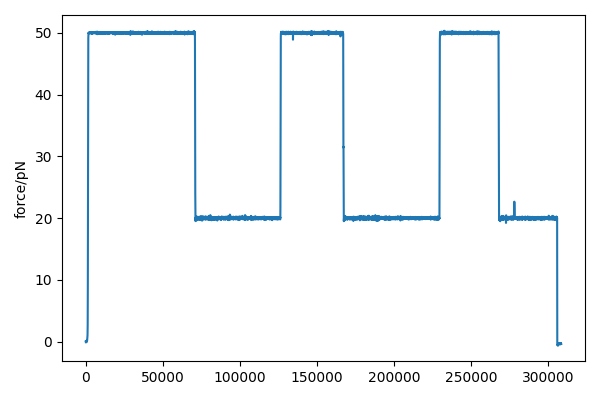

In [94]:
# run this step to find out the Time of ROI
time = tdms_file['FD Data']['Time (ms)'][:]
time = np.array(time)
force = tdms_file['FD Data']['Force Channel 0 (pN)'][:]
force = np.array(force)
distance = tdms_file['FD Data']['Distance 1 (um)'][:]
distance = np.array(distance)

# run this step to find out the Time of ROI
plt.figure(figsize=(6,4))
plt.plot(time,force)
# plt.plot(time,distance)
# plt.plot(distance,force)
plt.ylabel('force/pN')
plt.tight_layout()
plt.show()

In [95]:
# please enter cycle number of interest
cycle = input('please type in cycle number of interest(e.g.:01):')

# time_from_all = float(input('please type in the starting time of interest:'))
# time_to_all = float(input('please type in the ending time of interest:'))

time_from_exo = float(input('please type in the starting time of exo in ms:'))
time_to_exo = float(input('please type in the ending time of exo in ms:'))

time_from_pol = float(input('please type in the starting time of pol in ms:'))
time_to_pol = float(input('please type in the ending time of pol in ms:'))

In [96]:
# here you will select and analyze your interesting cycle with corresponding time range; 
# define a temporary index to compute time of ROI, and subsuquent ROI of force, distance
# indtemp_all = np.where((time <= time_to_all) & (time >= time_from_all))
indtemp_exo = np.where((time <= time_to_exo) & (time >= time_from_exo))
indtemp_pol = np.where((time <= time_to_pol) & (time >= time_from_pol))

# # all time range of event
# time_range_all = time[indtemp_all]
# force_range_all = force[indtemp_all]
# distance_range_all = distance[indtemp_all]

# exo time range of ROI
time_range_exo = time[indtemp_exo]
force_range_exo = force[indtemp_exo]
distance_range_exo = distance[indtemp_exo]

# pol time range of ROI
time_range_pol = time[indtemp_pol]
force_range_pol = force[indtemp_pol]
distance_range_pol = distance[indtemp_pol]

# all time range of ROI
time_range_all = np.append(time_range_exo, time_range_pol)
force_range_all = np.append(force_range_exo, force_range_pol)
distance_range_all = np.append(distance_range_exo, distance_range_pol)

In [97]:
# parameters for tWLC model: Peter Gross, et al. Nature Physics volume 7, pages731–736(2011)
# dsDNA contour length Lc = 2.85056um; persistent length Lp = 56nm
# the twist rigidity C=440 pN nm2;
# the stretching modulus S=1500 pN;
# the twist–stretch coupling g(F) is given by: g(F) =g0+g1F,where g0=−637 pN nm, g1=17 nm
EEDds,Lc,F,Lp,C,g0,g1,S = symbols('EEDds Lc F Lp C g0 g1 S', real=True)
C = 440
g0= -637
g1 = 17
Lc = 2.85056
Lp = 56
S = 1500
# tWLC model expression:
def tWLC(F):
    EEDds = Lc*(1-0.5*(4.1/(F*Lp))**0.5 + C*F/(-(g0+g1*F)**2 + S*C))
    return (EEDds)

# parameters for FJC model: Smith, S. B., et al. Science 271, 795–799 (1996).
# ssDNA contour length Lss = 4.69504um,
# Kuhn length b = 1.5nm (persistent length is 0.75nm),
# the stretching modulus S=800pN
EEDss,Lss,b,Sss = symbols('EEDss Lss b Sss', real=True)
Lss = 4.69504
b = 1.5
Sss = 800
# FJC model expression:
def FJC(F):
    EEDss = []
    for Fext in F:
        x  = Lss * (coth(Fext * b / 4.1) - 4.1 / (Fext * b)) * (1 + Fext / Sss)
        EEDss.append(x)
    EEDss = np.array(EEDss)
    return (EEDss)

# EEDss,Lss,b,Sss,Fext = symbols('EEDss Lss b Sss Fext', real=True)
# Lss = 4.69504
# b = 1.5
# Sss = 800
# # FJC model expression:
# def FJC(Fext):
#     EEDss  = Lss * (coth(Fext * b / 4.1) - 4.1 / (Fext * b)) * (1 + Fext / Sss)
#     return (EEDss)

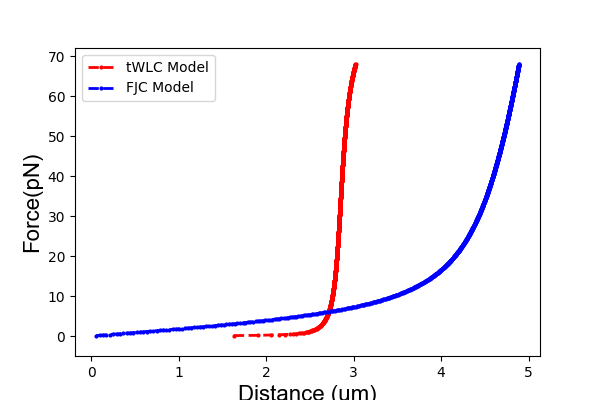

In [98]:
Force = np.linspace(0.1,68,1000)

plt.figure(figsize=(6,4))
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}


plt.xlabel('Distance (um)',fontdict=font)
plt.ylabel('Force(pN)',fontdict=font)
plt.plot(tWLC(Force),Force,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=2,label='tWLC Model')
plt.plot(FJC(Force),Force,color='b', marker='o', linestyle='dashed',linewidth=2, markersize=2,label='FJC Model')

plt.legend()
# plt.title('Experimental Data fit to tWLC and FJC Model',fontdict=font)
plt.ylim(-5,72)

plt.show()
plt.tight_layout()

# you can only see experimental data after you run the next code block 

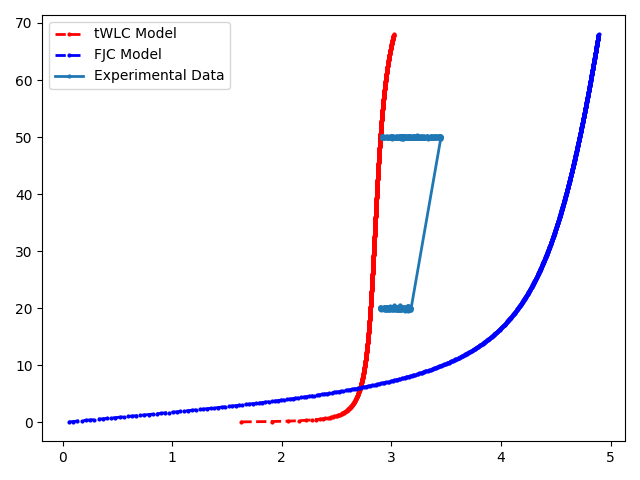

In [99]:
# Default bead size = 1.76um, by running this code to fit the right bead size
bead_size = 1.78

plt.figure()
plt.plot(tWLC(Force),Force,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=2,label='tWLC Model')
plt.plot(FJC(Force),Force,color='b', marker='o', linestyle='dashed',linewidth=2, markersize=2,label='FJC Model')
# plot experimental data together with 
plt.plot(distance_range_all - bead_size, force_range_all, marker='o', linestyle='solid',linewidth=2, markersize=2,label='Experimental Data')
plt.legend()
plt.tight_layout()
plt.show()
    
# plt.savefig(filename.replace('.tdms', '-cycle#') + cycle + '-DataFit2Model'+'.eps', dpi=300)

End-to-end distance between two optically trapped beads consists ssDNA fraction and dsDNA fraction. By calculating:
- *ssDNA percentage* : ssDNA % =(𝐸𝐸𝐷 −𝑡𝑊𝐿𝐶(𝐹))/(𝐹𝐽𝐶(𝐹) -SSB_factor(F)−𝑡𝑊𝐿𝐶(𝐹))
- *dsDNA percentage* : dsDNA % =1-ssDNA % , 
- *ssDNA/dsDNA junction position* could be obtained following: Junction position =(𝑠𝑠% ∗𝐹𝐽𝐶(𝐹))/(𝑠𝑠% ∗𝐹𝐽𝐶(𝐹)+𝑑𝑠% ∗𝑒𝑊𝐿𝐶(𝐹) ) * EED). 
- the SSB_factor(F) defines the shortening distance by the SSB binding

Junction position changes is then plotted as a function of time.

In [100]:
# Default exo_force is 50pN and pol_force 20pN 
exo_force = 50
pol_force = 20

SSB_factor = 0.03 #10pN; note this value is an estimate to calibrate the effect of SSB binding
# SSB_factor = 0.02 #20pN; note this value is an estimate to calibrate the effect of SSB binding 
# SSB_factor = 0 # 50pN;  note this value is an estimate to calibrate the effect of SSB binding

# calculating the length of dsDNA under exo and pol force
dsDNA_exo_ref = tWLC(exo_force)
dsDNA_pol_ref = tWLC(pol_force)

# calculating the length of ssDNA under exo and pol force
ssDNA_exo_ref = 4.69504 * (coth(exo_force * 1.5 / 4.1) - 4.1 / (exo_force * b)) * (1 + exo_force / 800)
ssDNA_pol_ref =4.69504 * (coth(pol_force * 1.5 / 4.1) - 4.1 / (pol_force * b)) * (1 + pol_force / 800)

In [101]:
# calculating ssDNA under exo and pol force
ssDNA_exo_percentage = (distance_range_exo - bead_size - dsDNA_exo_ref)/(ssDNA_exo_ref - SSB_factor - dsDNA_exo_ref)
ssDNA_pol_percentage = (distance_range_pol - bead_size - dsDNA_pol_ref)/(ssDNA_pol_ref - SSB_factor - dsDNA_pol_ref)
ssDNA_all_percentage = np.append(ssDNA_exo_percentage,ssDNA_pol_percentage)

# calculating basepairs
# Construct of pkyb1 DNA has a length of 8393bp
basepairs = (1-ssDNA_all_percentage) * 8393

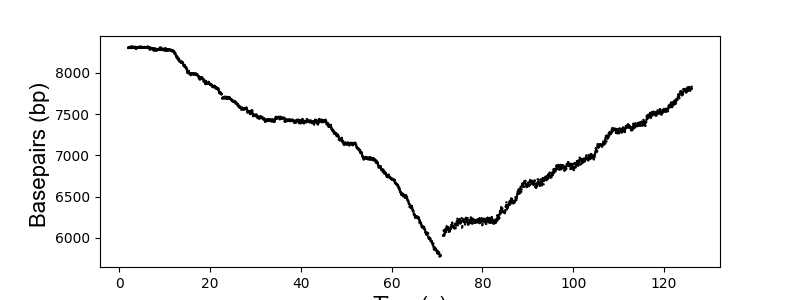

In [102]:
# plot ssDNA% as a function of time
plt.figure(figsize=(8,3))
# font = {'family': 'Arial', 'weight': 'normal', 'size': 16}

plt.ylabel('Basepairs (bp) ',fontdict=font)
plt.xlabel('Time(s)',fontdict=font)
plt.scatter(time_range_all/1000,(1-ssDNA_all_percentage)  * 8393,color='black', linestyle='dashed',s=0.5,label='End-to-End Distance')

plt.show()
plt.tight_layout()

# plt.savefig(filename.replace('.tdms', '-cycle#') + cycle + '-ssDNA_percentage'+'.eps', dpi=300)

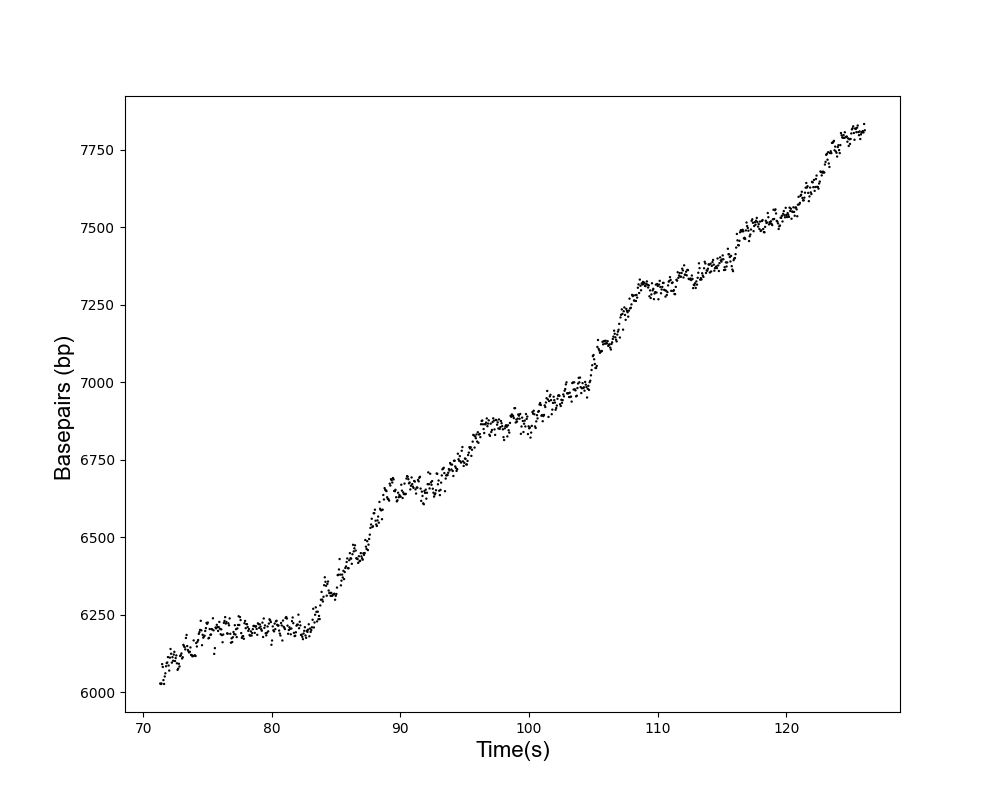

In [103]:
# plot ssDNA% as a function of time, only in the rang of pol events
plt.figure(figsize=(10,8))
# font = {'family': 'Arial', 'weight': 'normal', 'size': 16}

plt.ylabel('Basepairs (bp) ',fontdict=font)
plt.xlabel('Time(s)',fontdict=font)
plt.scatter(time_range_pol/1000,(1-ssDNA_pol_percentage)  * 8393,color='black', linestyle='dashed',s=0.5,label='End-to-End Distance')
# plt.ylim(0,1500)

# plt.xlim(8.5,158)
plt.show()
plt.tight_layout()

# plt.savefig(filename.replace('.tdms', '-cycle#') + cycle + '-ssDNA_percentage'+'.eps', dpi=300)

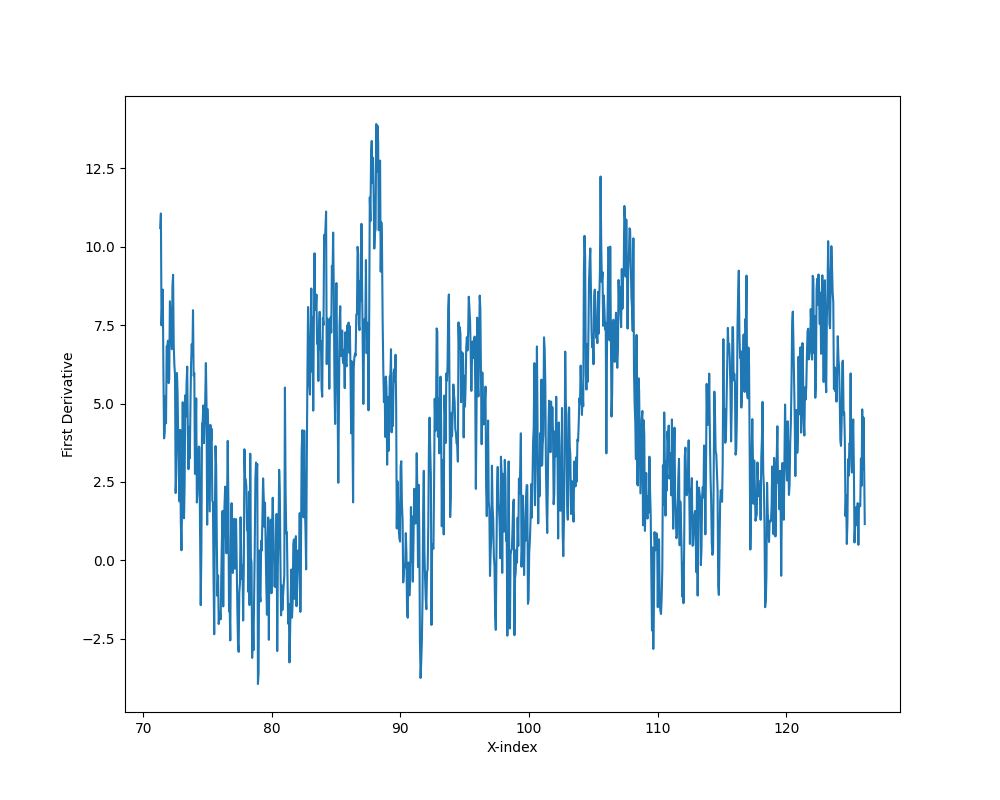

In [104]:
# Let's start to detect the change points, first by calculating the first derivitives
from bayesian_changepoint_detection.piecewise_change_functions import *

from bayesian_changepoint_detection.priors import const_prior
from functools import partial

from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection
import bayesian_changepoint_detection.offline_likelihoods as offline_ll

from bayesian_changepoint_detection.x_index_averager import average_indices

x_values = time_range_pol/1000
y_values = 1-ssDNA_pol_percentage

# set the window size and scaling factor to get step-like first-derivative trace
# Calculate the optimal window size based on the estimated noise standard deviation
window_size = optimal_window_size(estimate_noise_std(y_values, scaling_factor=1.3))
filtered_y_values = moving_window_filter(y_values, window_size)
# Calculate the filtered_y_values,first_derivative_values,fitted_y_values and plot the data
first_derivative_values = first_derivative(x_values, y_values, window_size)
# filtered_first_derivative = savgol_filter(first_derivative_values, window_length=5, polyorder=3)

# In case the derivative is too small, you might risk detecting nothing, so we multiply a manifying factor.
data = first_derivative_values*1000
# data = 1-ssDNA_pol_percentage

plt.figure(figsize=(10,8))
plt.xlabel('X-index')
plt.ylabel('First Derivative')
plt.plot(x_values, data)
plt.show()

## Bayesian Changepoint Detection

Lets compute the probability of changepoints at each time step. We need two things for that. First a prior of how probable is it to have two successive changepoints with the distance `t`. The second thing is a model of the likelihood of data in a sequence `[s, t]` of the data, given that in this sequence there is *no* changepoint.

For this example we assume a uniform prior over the length of sequences (`const_prior`) and a piecewise gaussian model (`gaussian_obs_log_likelihood`).

Compute the likelihood of changepoints on data. `offline_changepoint_detection()`

    Parameters:
    Inputs:
        data    -- the time series data
        truncate  -- the cutoff probability 10^truncate to stop computation for that changepoint log likelihood

    Outputs:
        P  -- the log-likelihood of a datasequence [t, s], given there is no changepoint between t and s
        Q -- the log-likelihood of data
        Pcp --  the log-likelihood that the i-th changepoint is at time step t. To actually get the probility of a changepoint at time step t sum the probabilities.

The `offline_changepoint_detection()` function returns three things: `Q[t]`, the log-likelihood of data `[t, n]`, `P[t, s]`, the log-likelihood of a datasequence `[t, s]`, given there is no changepoint between `t` and `s` and `Pcp[i, t]`, the log-likelihood that the `i`-th changepoint is at time step `t`. To actually get the probility of a changepoint at time step `t` sum the probabilities.

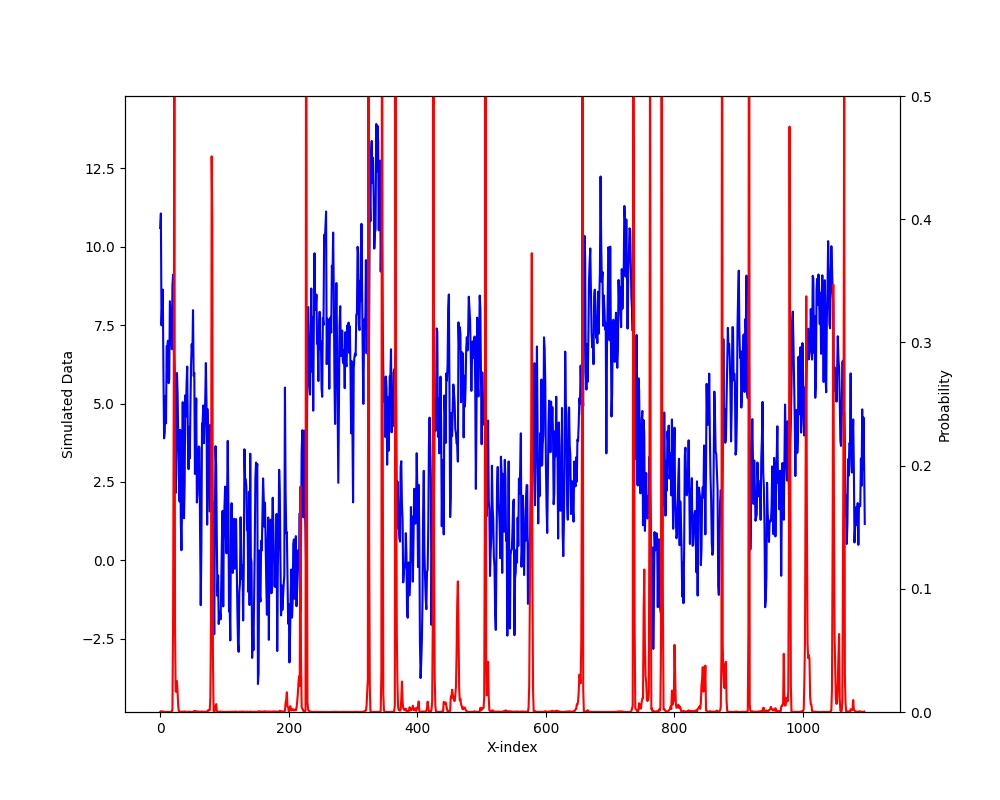

In [105]:
# Let's start to analyze the trace, in this case the first derivative
prior_function = partial(const_prior, p=1/(len(data) + 1))
Q, P, Pcp = offline_changepoint_detection(data, prior_function ,offline_ll.StudentT(),truncate=-40)

# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# Plot the data
ax1.plot(data[:], color='blue')
ax2.plot(np.exp(Pcp).sum(0), color='red')

# Set the y-limits for the second axis
ax2.set_ylim(0,0.5)

# Set the x-label and y-label for the first axis
ax1.set_xlabel('X-index')
ax1.set_ylabel('Simulated Data')

# Set the y-label for the second axis
ax2.set_ylabel('Probability')

# Show the plot
plt.show()

In case you could't get any detected steps (showing all the prob too small),that's maybe due to the small values of your data, thus showing no significant steps been detected. You can simply multipy your data/y_values by 100, then do the same steps.

Before proceeding to further analysis, we need to filter those less probably based on our domain knowledge. We can tune the filter with two parameters. `prob_threshold` and `closeness_threshold`.
- `prob_threshold`: sets a threshold, only above which is considered as a real change-point; normally 0.1-0.2 works good. 
- `closeness_threshold`: sets a threshold, only wider than which is considered a new change-point, otherwise will be grouped and averaged into the previous one. 

In [106]:
# set your threshold here
prob_threshold = 0.1
closeness_threshold = 50

averaged_indices = average_indices(prob_threshold, closeness_threshold, Pcp)

# for index in averaged_indices:
#     print(index)
# Add the first and last index
# averaged_indices = np.concatenate([[np.arange(len(x_values))[0]], averaged_indices, [np.arange(len(x_values))[-1]]])

print (averaged_indices)

[22, 80, 224, 346, 465, 578, 656, 759, 895, 1020]


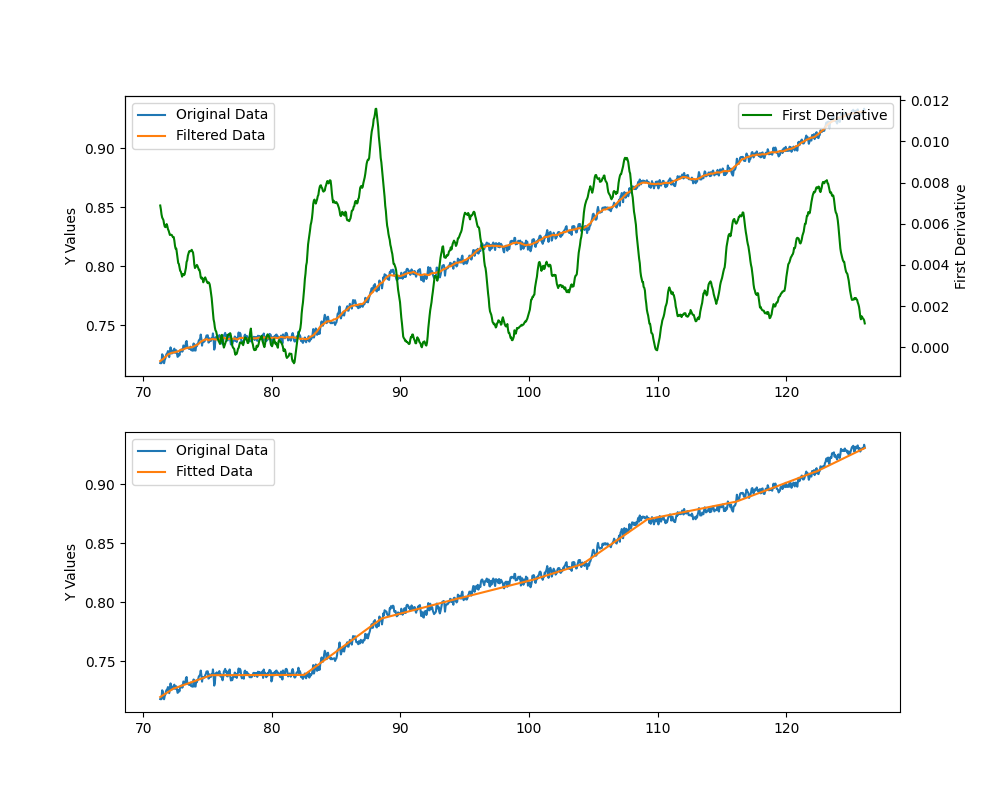

In [107]:
# Recalculate step sizes based on the optimal step locations
recalculated_step_sizes = recalculate_step_sizes(data[:], averaged_indices[:])

# Calculate the filtered_y_values,first_derivative_values,fitted_y_values and plot the data
filtered_y_values = moving_window_filter(y_values, window_size)
first_derivative_values = first_derivative(x_values, filtered_y_values, window_size)
fitted_y_values = reconstruct_fitted_data(x_values, filtered_y_values, averaged_indices)

plot_data(x_values, y_values, filtered_y_values, first_derivative_values, fitted_y_values)
plt.savefig(filename.replace('.tdms', 'changepoint_detected') + '-cycle#'+ cycle +'.png', dpi=300)

In [108]:
# calculate the data and save all the analyzed data in an excel file
cp_locations = np.concatenate([[x_values[0]], x_values[averaged_indices], [x_values[-1]]])
step_sizes = recalculated_step_sizes
plateau_lengths = np.diff(cp_locations)
velocity = step_sizes/plateau_lengths[:-1]

basepair_data = {'time': time_range_all,
        'ssDNA_all_percentage': ssDNA_all_percentage,
        'basepairs': basepairs}
CP_data = {'processivity': step_sizes,
        'duration': plateau_lengths[:-1],
        'rate': velocity}

df1 = pd.DataFrame(basepair_data)
df2 = pd.DataFrame(CP_data)

excel_filename = filename.replace('.tdms', '-cycle#') + cycle + '.xlsx'

with pd.ExcelWriter(excel_filename) as writer:
    df1.to_excel(writer, sheet_name='Basepair Data')
    df2.to_excel(writer, sheet_name='CP Data')
